In [1]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import statistics as st
import networkx as nx
import matplotlib.pyplot as plt
import glob
from networkx.algorithms import community

# Input measures

In [2]:
measuresDataFrames={}
measures=['averageNeighbor','betweenness','bridging','closeness','clusteringcoeff','degree','eccentricity','eigenvector','kcore','leverage','participation']
for name in ['HPRD','HINT','Human','ReactomeFI','Collaboration','barabasi_albert_m2']:
    df=pd.DataFrame()
    for m in measures:
        path=glob.glob('inputs\\'+m+'_'+name+'.tsv')[0]
        if m == 'averageNeighbor':
            df['AvgNeighbors']=pd.read_csv(path,sep='\t')[m]
        elif m == 'clusteringcoeff':
            df['Clustering']=pd.read_csv(path,sep='\t')[m]
        else:
            df[m.capitalize()]=pd.read_csv(path,sep='\t')[m]

    if(name=='Human'):
        name='MINT'
    elif(name=='erdos_renyi'):
        name='Erdos-Renyi'
    elif(name=='barabasi_albert_m2'):
        name='Barabasi Albert'
            
    measuresDataFrames[name]= df

In [3]:
measuresDataFrames['HPRD'].head(2)

,AvgNeighbors,Betweenness,Bridging,Closeness,Clustering,Degree,Eccentricity,Eigenvector,Kcore,Leverage,Participation
0,25.0,0.000304,0.000216,0.241517,0.166667,4,9.0,0.001016,3,-0.5714,0.75
1,2.0,0.000412,0.000037,0.203864,0.000000,4,10.0,0.000121,2,0.3833,0.00


# Input Network

In [4]:
networks={}
df = pd.read_csv('inputs/HPRD.tsv',sep='\t',names=['Source','Target'])
networks['HPRD'] = nx.from_pandas_edgelist(df,source='Source',target='Target')
networks['HPRD'].name = 'HPRD'
print(nx.info(networks['HPRD']),end='\n\n')

df = pd.read_csv('inputs/HINT.tsv',sep='\t',names=['Source','Target'])
networks['HINT'] = nx.from_pandas_edgelist(df,source='Source',target='Target')
networks['HINT'].name = 'HINT'
print(nx.info(networks['HINT']),end='\n\n')

networks['MINT']=nx.from_pandas_edgelist(pd.read_csv('inputs/MINT.txt',sep='\t',usecols=[0,1],header=None),source=0,target=1)
networks['MINT'].name='MINT'
print(nx.info(networks['MINT']),end='\n\n')

df = pd.read_csv("inputs/Reactome2019_FIsInGene_020720_with_annotations.txt",sep='\t')
networks['ReactomeFI'] = nx.from_pandas_edgelist(df,source='Gene1',target='Gene2')
networks['ReactomeFI'].name = 'Reactome'
print(nx.info(networks['ReactomeFI']),end='\n\n')

networks['Collaboration']=nx.read_edgelist('inputs/collaboration.edgelist.txt')
networks['Collaboration'].name='Collaboration'
print(nx.info(networks['Collaboration']),end='\n\n')

networks['Barabasi Albert']=nx.read_gml('inputs/barabasi_albert_m2.gml')
networks['Barabasi Albert'].name='Barabasi Albert'
print(nx.info(networks['Barabasi Albert']),end='\n\n')

Name: HPRD
Type: Graph
Number of nodes: 9465
Number of edges: 37039
Average degree:   7.8265

Name: HINT
Type: Graph
Number of nodes: 12543
Number of edges: 62590
Average degree:   9.9801

Name: MINT
Type: Graph
Number of nodes: 13363
Number of edges: 45924
Average degree:   6.8733

Name: Reactome
Type: Graph
Number of nodes: 14071
Number of edges: 268857
Average degree:  38.2143

Name: Collaboration
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784

Name: Barabasi Albert
Type: Graph
Number of nodes: 10000
Number of edges: 69951
Average degree:  13.9902



# Assortativity

In [8]:
def averageNeighborsDegree(G,node):
    neighbors=list(nx.neighbors(G,node))
    if(len(neighbors)==0):
        return 0 
    else:
        return sum([nx.degree(G,n) for n in neighbors])/len(neighbors)

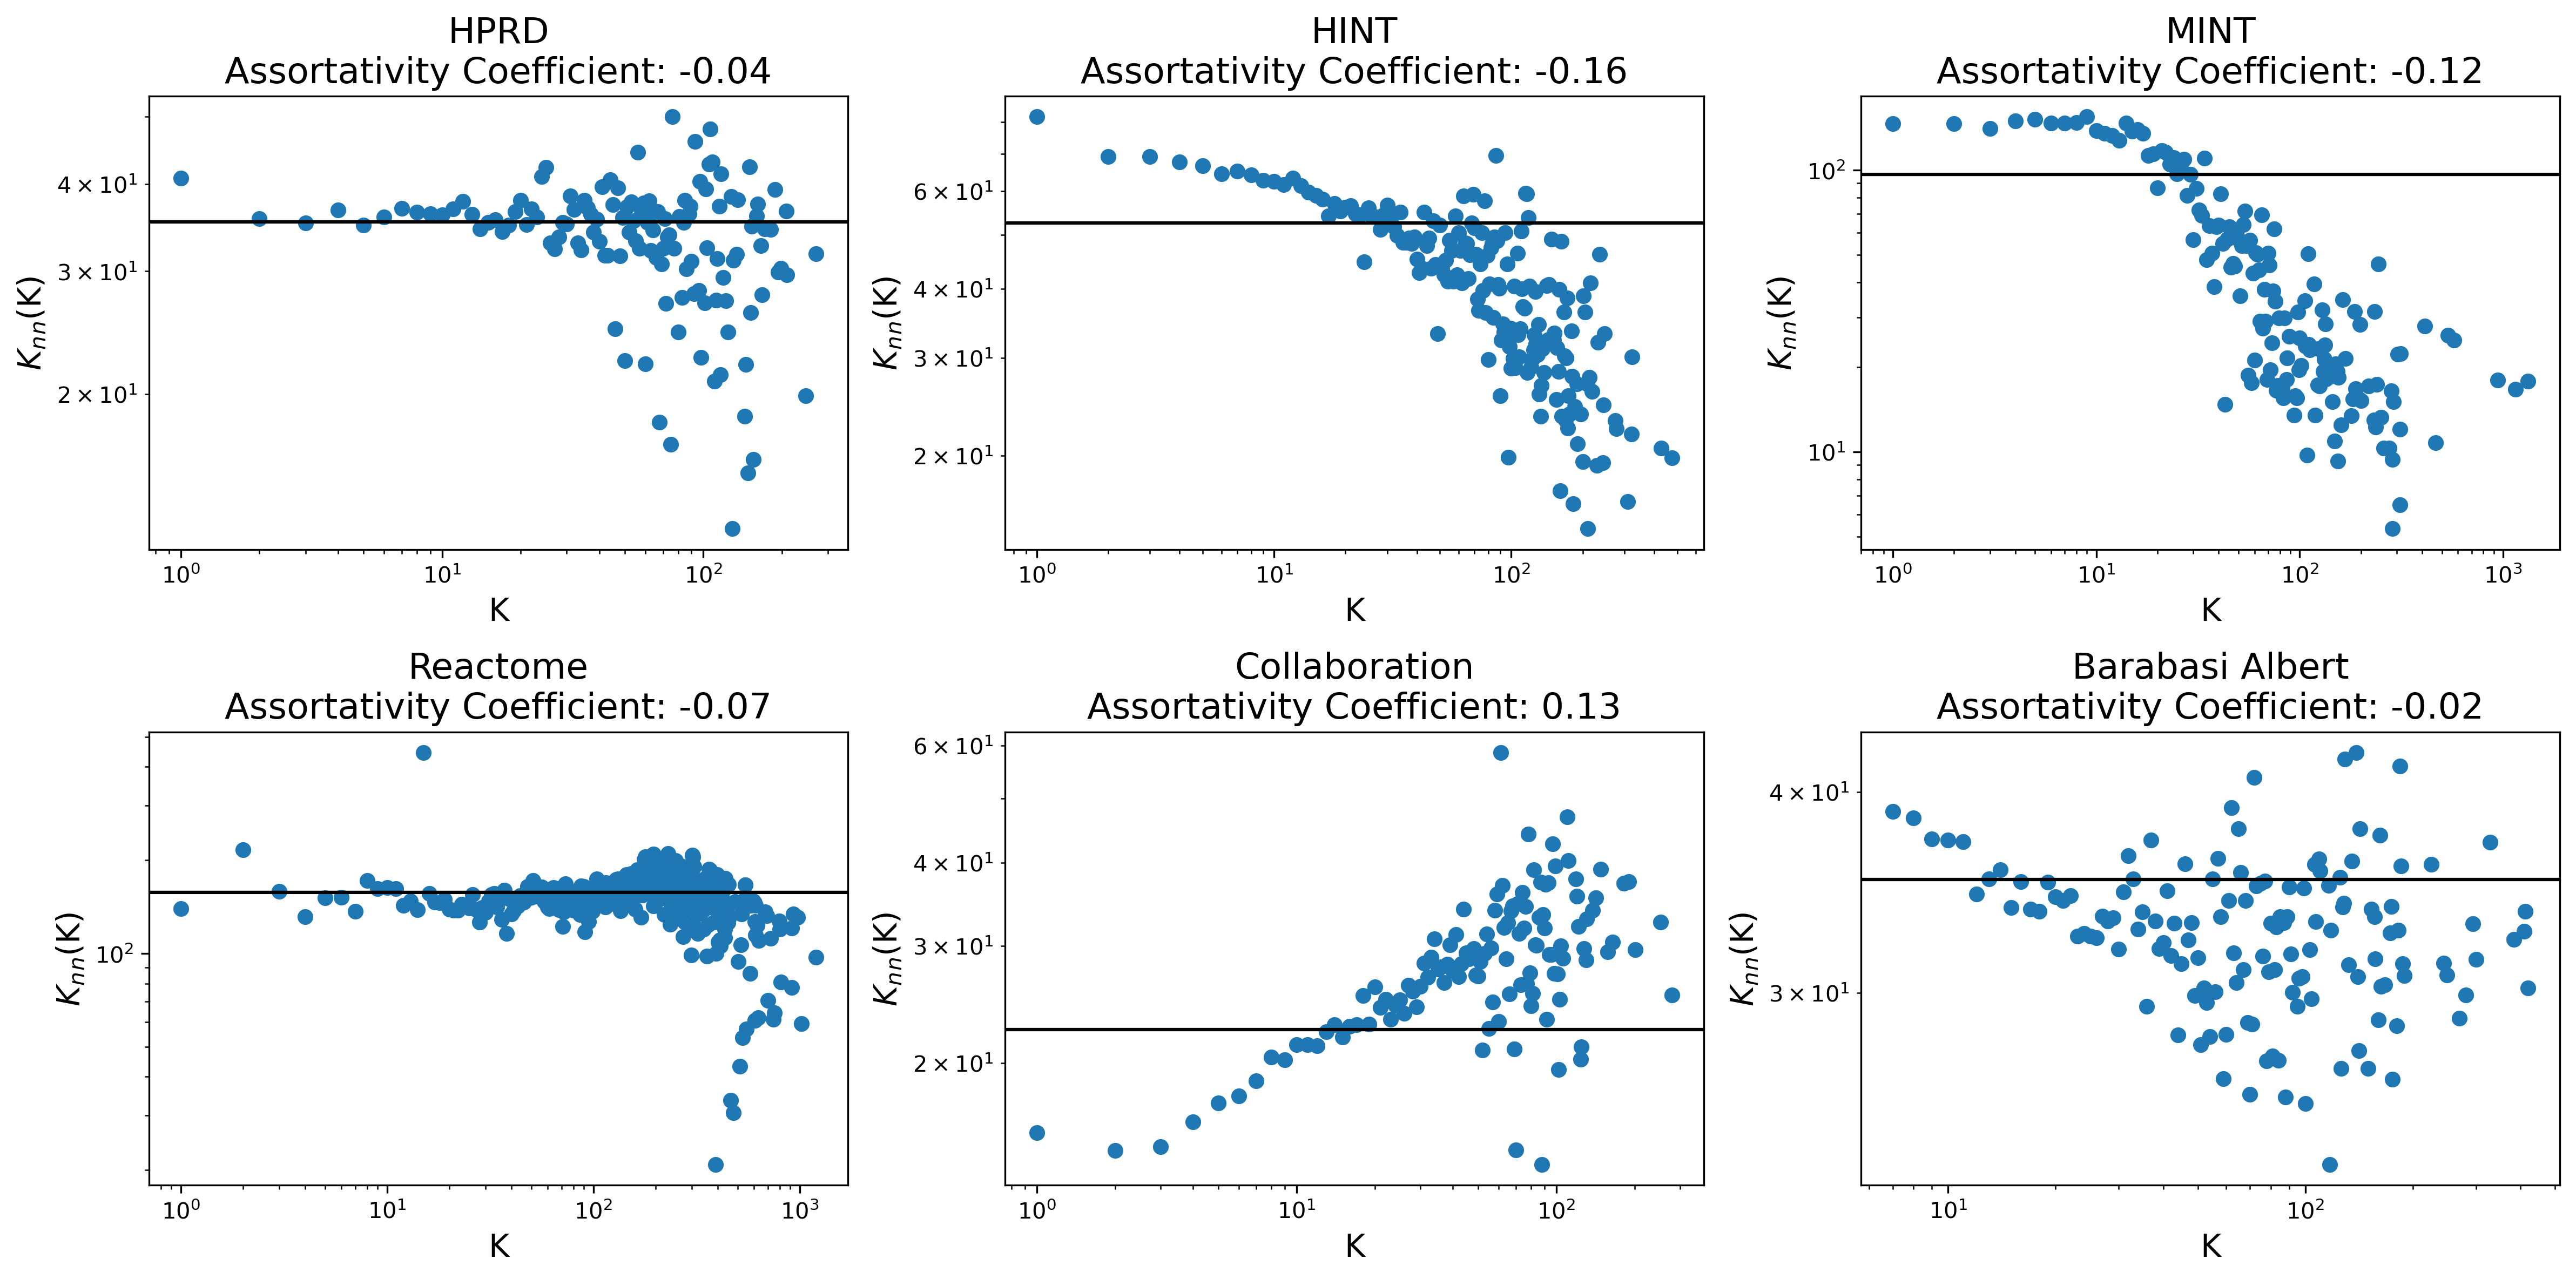

In [20]:
plt.figure(figsize=(16,8),dpi=300)  
for i,name in enumerate(networks):
    plt.subplot(2,3,i+1)
    
    G=networks[name]
    #Get only the Largest Connect Component (LCC)
    G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    nodeWithDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in nodeWithDegreeK:
            nodeWithDegreeK[k]=[node]
        else:
            nodeWithDegreeK[k].append(node)
    #Get the average neighbors degree for every node with degree'k'
    for k in nodeWithDegreeK:
        means=0
        for node in nodeWithDegreeK[k]:
            means+=averageNeighborsDegree(G,node)
        nodeWithDegreeK[k]=round(means/len(nodeWithDegreeK[k]),2)

    #Plot the distribution
    plt.loglog(list(nodeWithDegreeK.keys()),list(nodeWithDegreeK.values()),'o')

    #Plot the line for a random prediction
    degree = list(dict(G.degree).values())
    neutralNetwork=round((st.variance(degree) + st.mean(degree)**2)/st.mean(degree),2)
    ylim=plt.gca().get_ylim()
    xlim=plt.gca().get_xlim()
    randomPrediction=[neutralNetwork for x in range(int(xlim[1]*1.1))]    
    
    plt.loglog(range(int(xlim[1]*1.1)),randomPrediction,'-',color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('K',fontsize=14)
    plt.ylabel(r'$K_n$'r'$_n$(K)',rotation = 90,fontsize=14)
    plt.title(G.name+'\n'+'Assortativity Coefficient: '+str(round(nx.assortativity.degree_assortativity_coefficient(G),2)),fontsize=16)
    plt.tight_layout()
    
plt.savefig("ouput/3.2 Assortatividade.png", format='png', dpi=550)
plt.savefig("ouput/3.2 Assortatividade.pdf", format='pdf')
plt.show()

# Communities

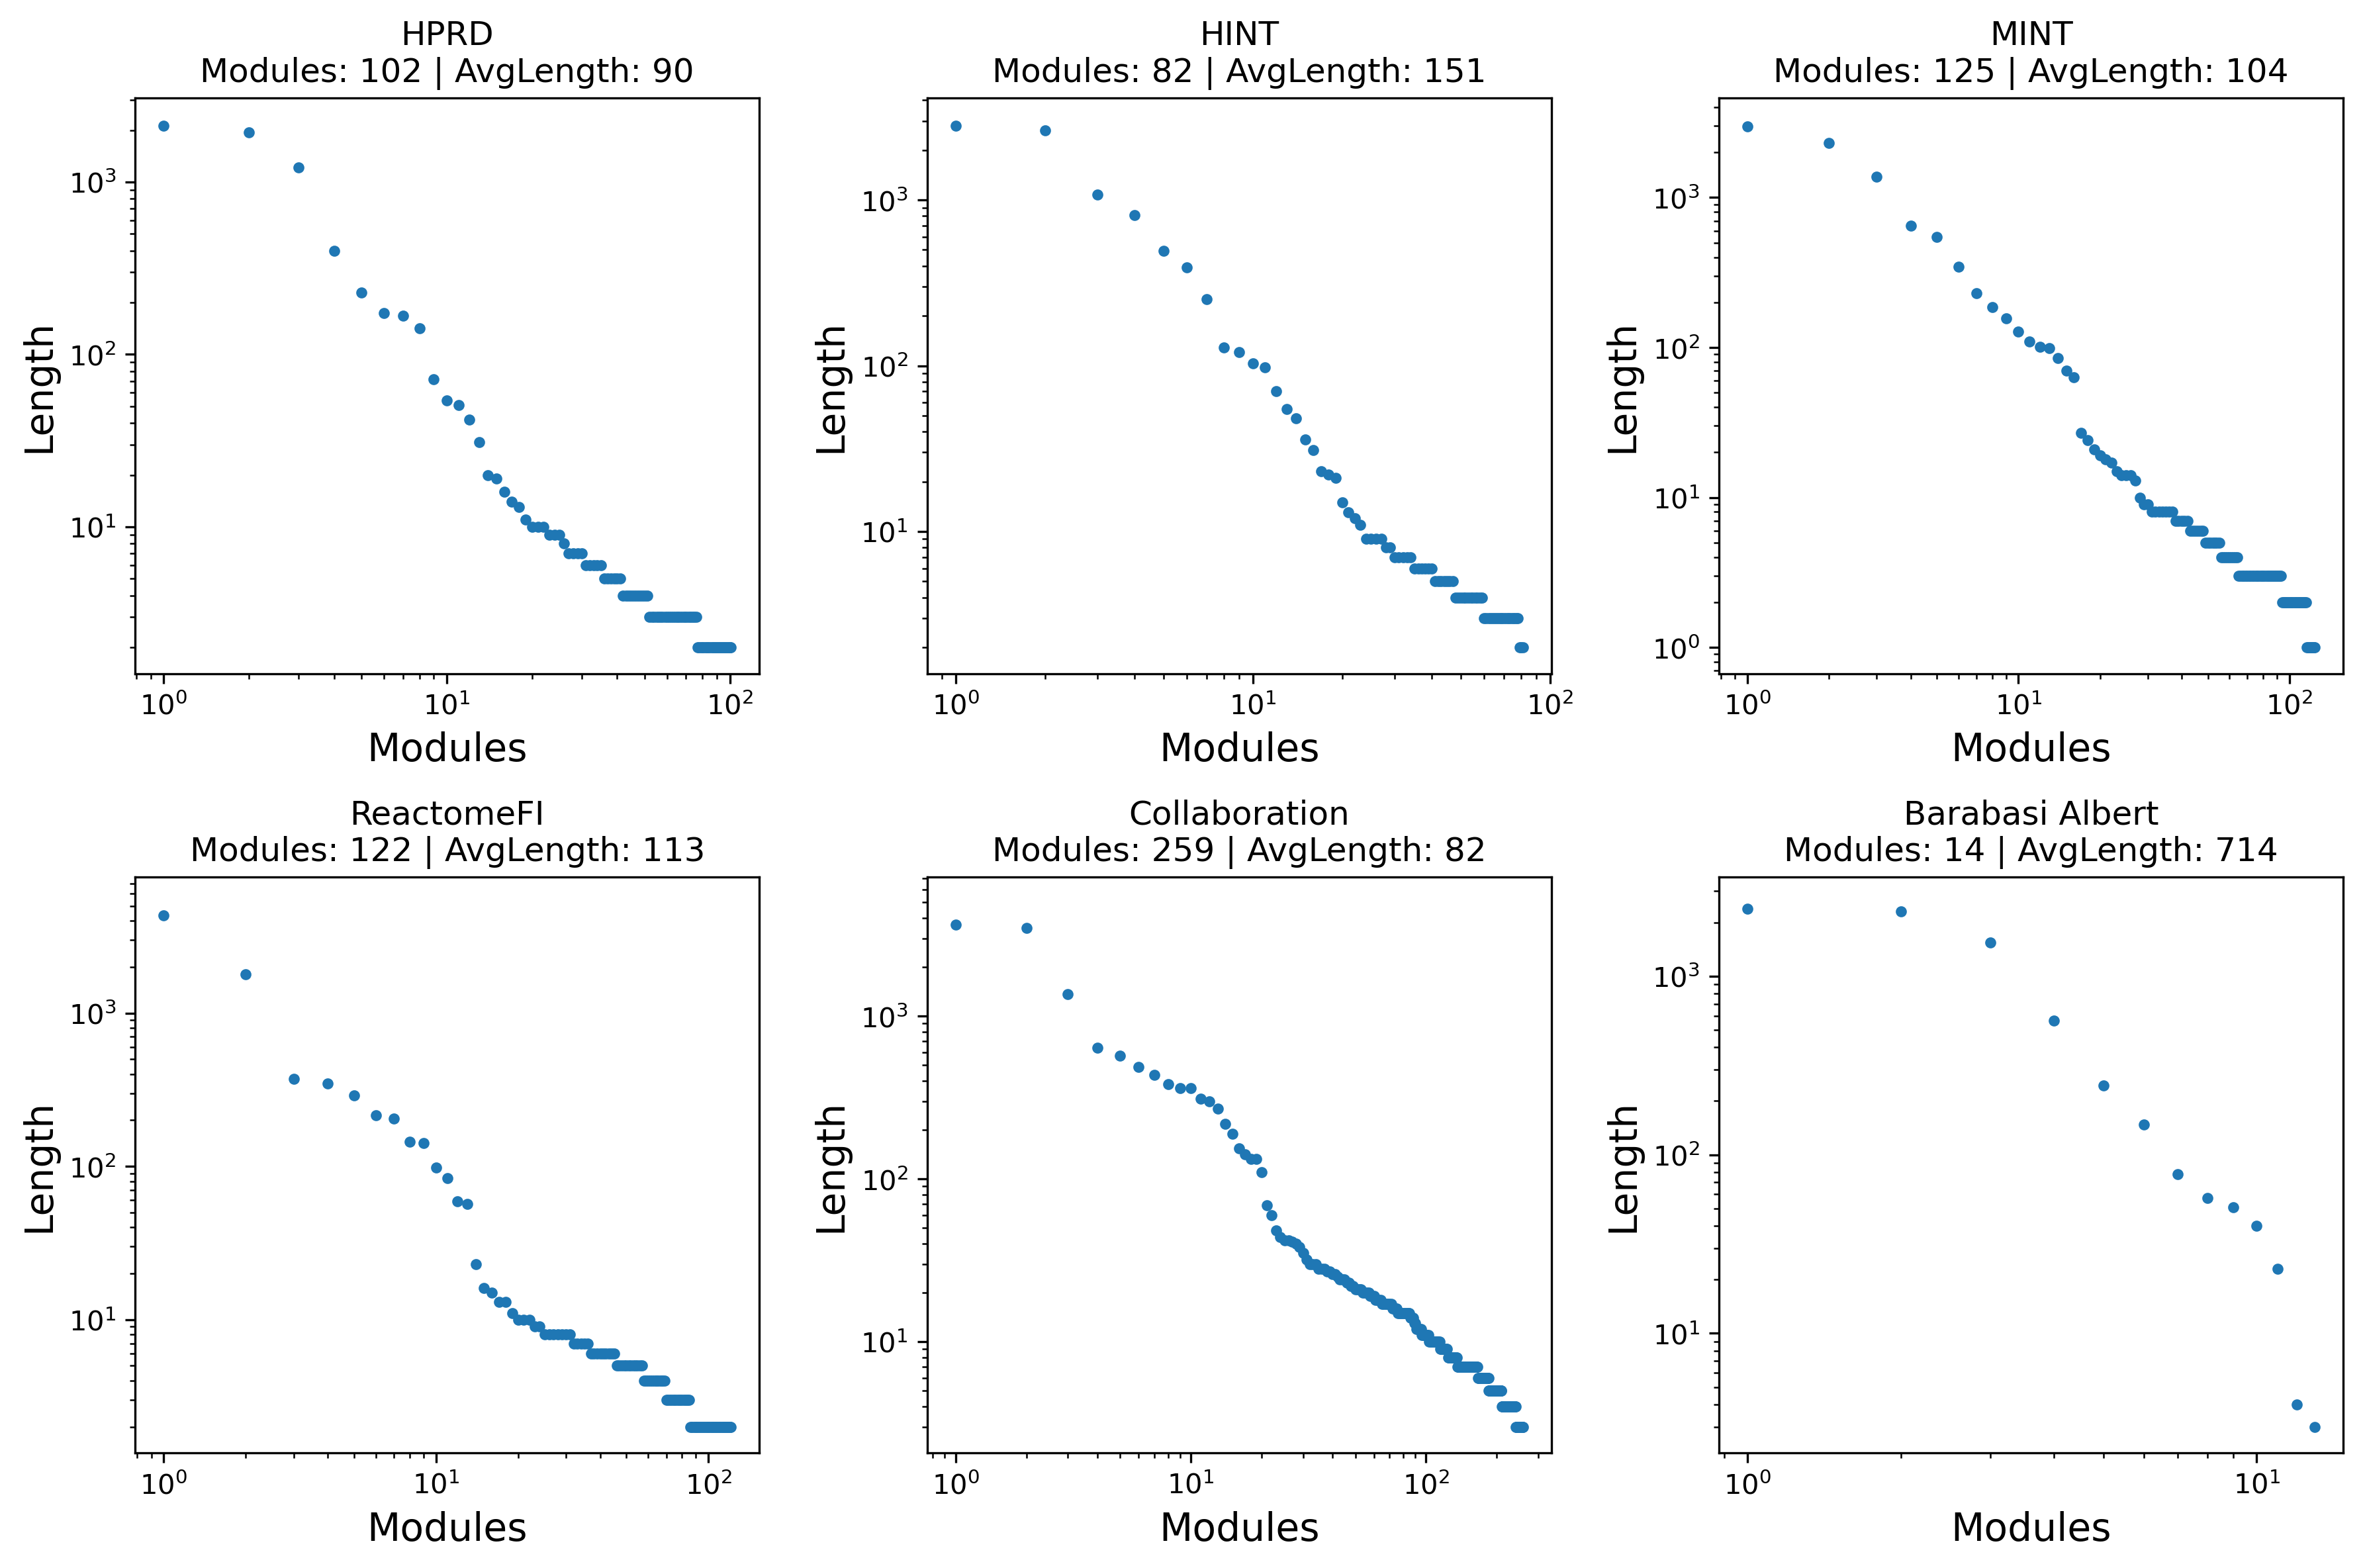

In [44]:
plt.figure(figsize=(12,8),dpi=300)  
for i,name in enumerate(networks):
    plt.subplot(2,3,i+1)
    
    G=networks[name]
    #Get only the Largest Connect Component (LCC)
    G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    com = community.greedy_modularity_communities(G)
    sizes = [len(c) for c in com]
    plt.loglog(sizes,'.')
    plt.xlabel('Modules',fontsize=11)
    plt.ylabel('Length',rotation = 90,fontsize=11)
    plt.title(name+'\nModules: '+str(len(sizes))+' | '+'AvgLength: '+str(int(np.mean(sizes))),fontsize=15)
    plt.tight_layout()
    
plt.savefig("ouput/3.2 Modules.png", format='png', dpi=550)
plt.savefig("ouput/3.2 Modules.pdf", format='pdf')
plt.show()

# Clustering and Density

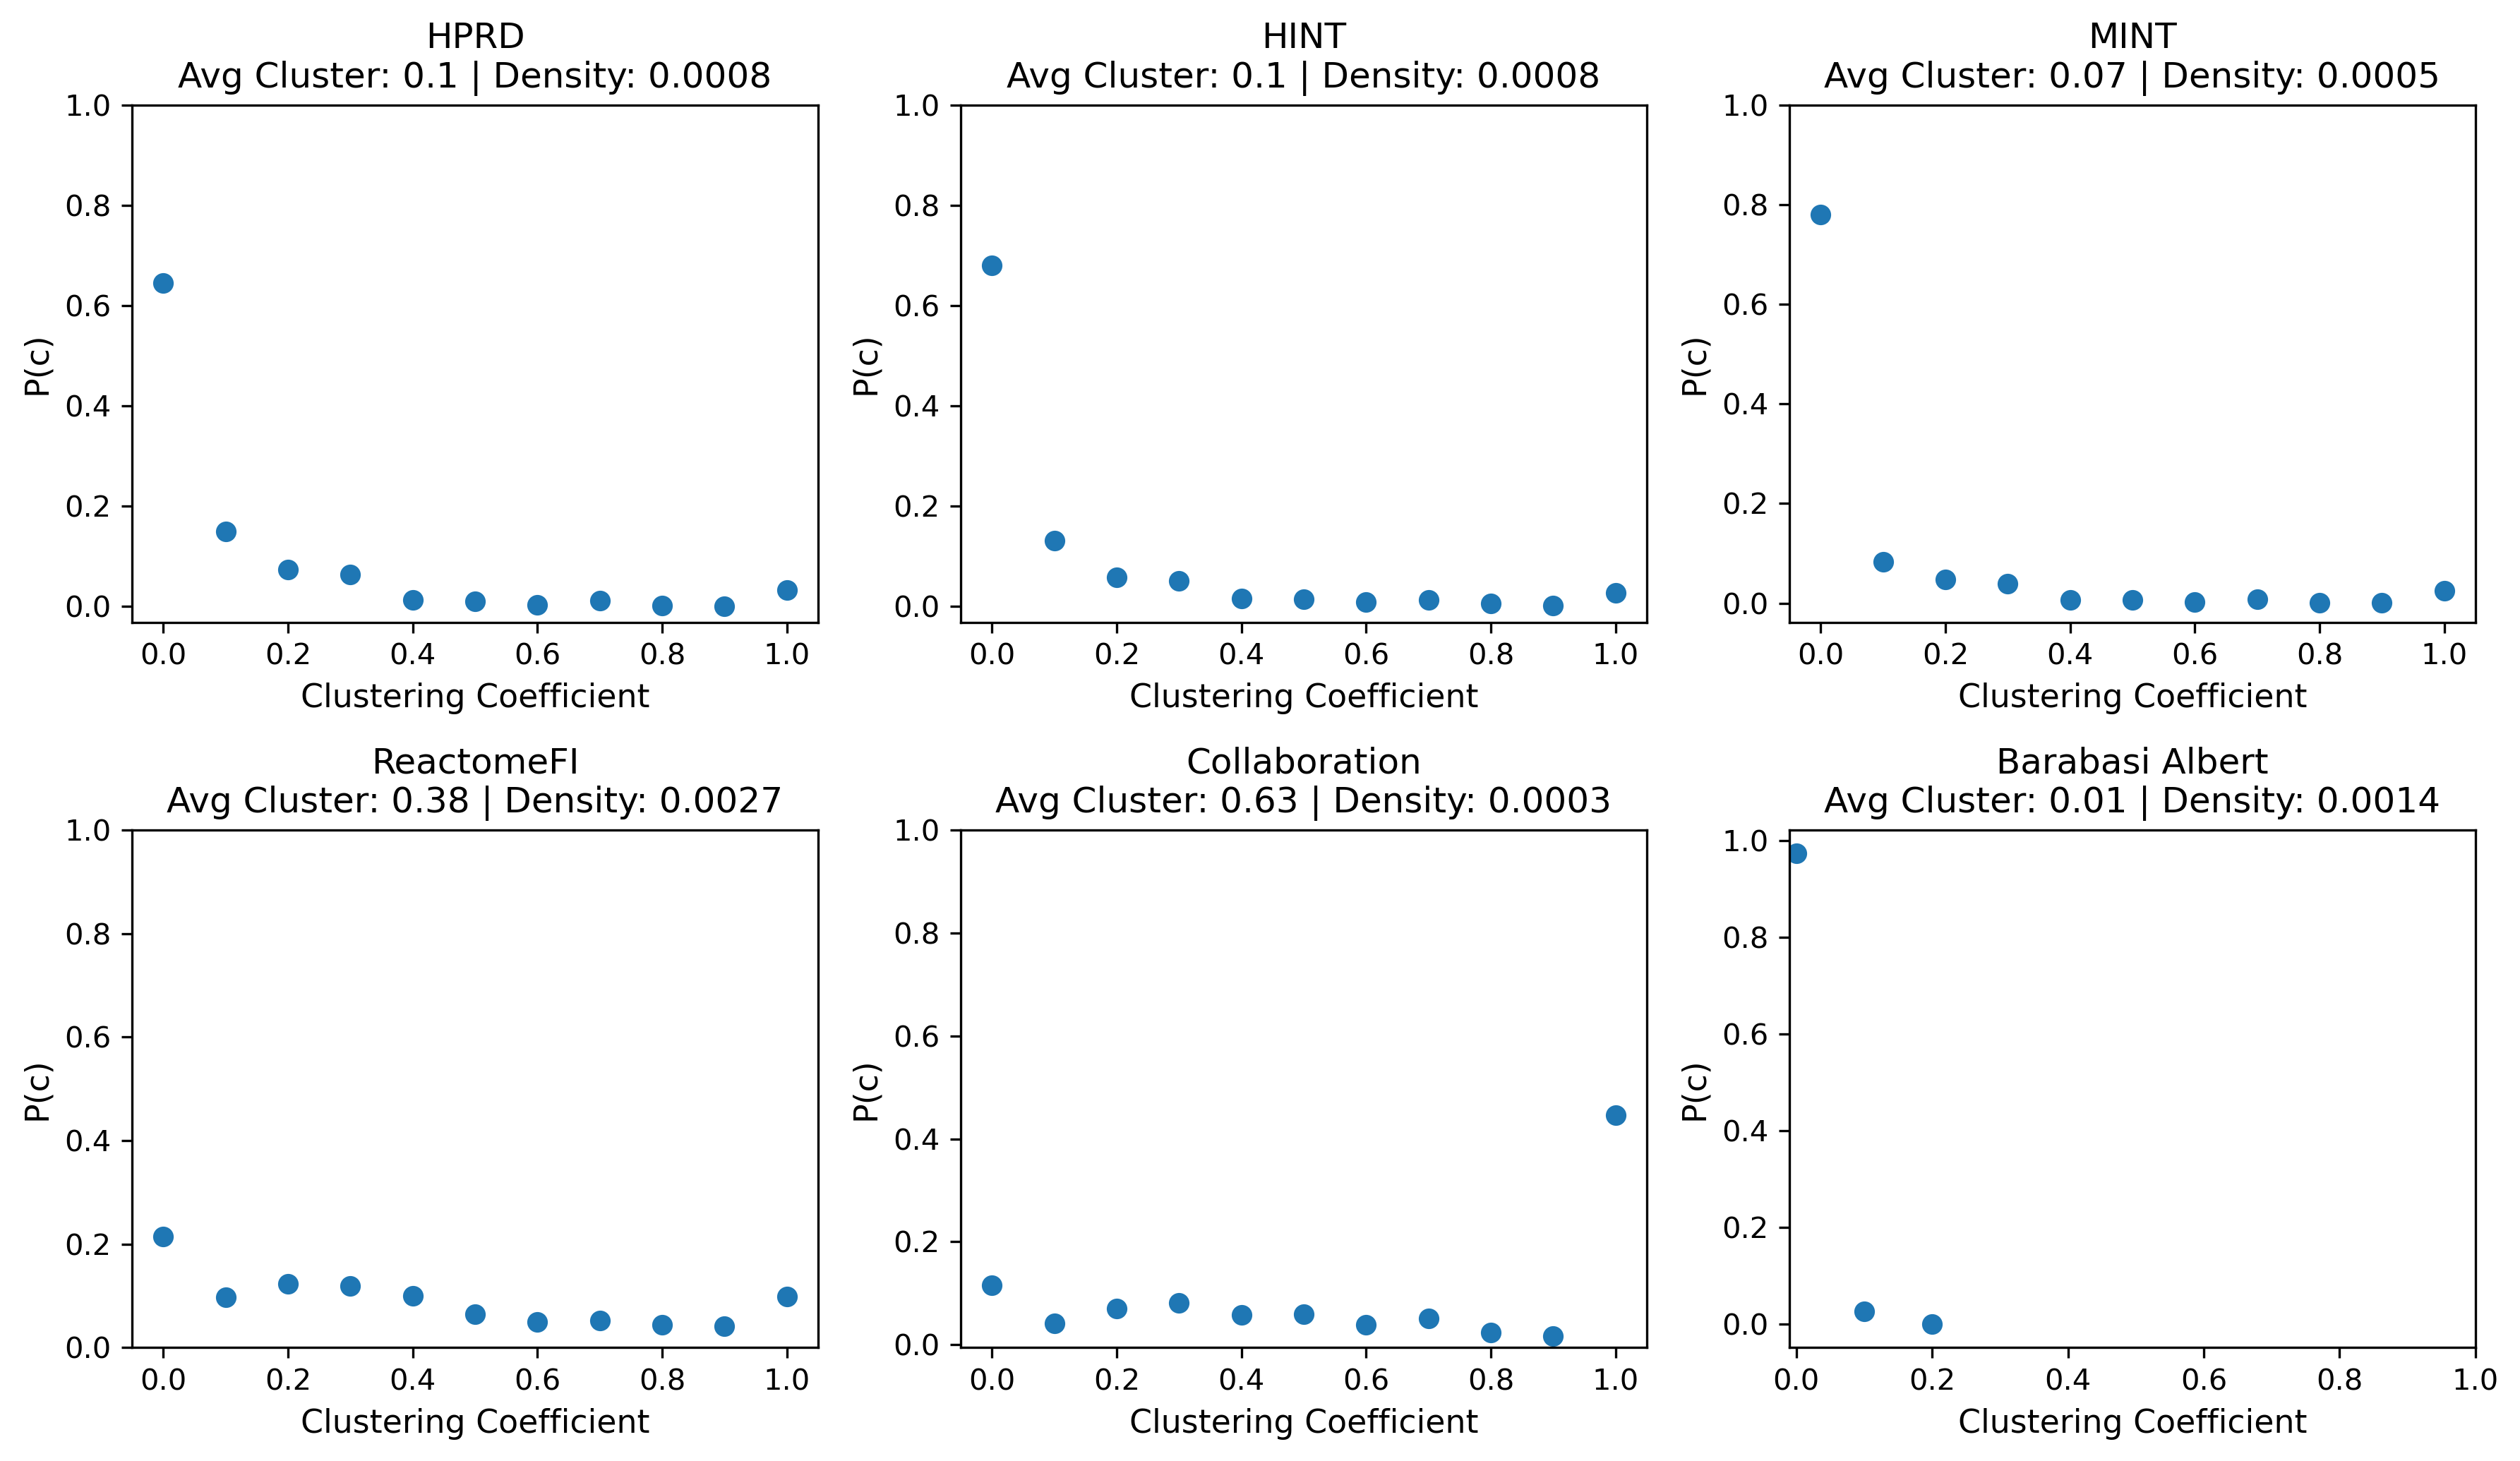

In [121]:
plt.figure(figsize=(12,7),dpi=300)  
for i,name in enumerate(networks):
    plt.subplot(2,3,i+1)
    
    mean = round(np.mean(measuresDataFrames[name]['Clustering']),2)
    clusterProbCount = [round(c,1) for c in measuresDataFrames[name]['Clustering']]

    clusterProb={}
    total = len(clusterProbCount)
    for c in clusterProbCount:
        if c in clusterProb:
            clusterProb[c]+=1
        else:
            clusterProb[c]=1

    for c in clusterProb:
        clusterProb[c]=clusterProb[c]/total

    clusterProb = dict(sorted(clusterProb.items(), key=lambda x:x[0]))

    plt.plot(list(clusterProb.keys()),list(clusterProb.values()),'o')
    plt.xticks(np.arange(0,1.1,0.2))
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xlabel("Clustering Coefficient",fontsize=11)
    plt.ylabel("P(c)",fontsize=11)
    plt.title(name+'\nAvg Cluster: '+str(mean)+' | Density: '+str(round(nx.density(networks[name]),4)),fontsize=12)
    plt.tight_layout()
    
plt.savefig("ouput/3.2 Clustering.png", format='png', dpi=550)
plt.savefig("ouput/3.2 Clustering.pdf", format='pdf')
plt.show()

# Eccentricity and Diamater

<Figure size 3600x2100 with 0 Axes>

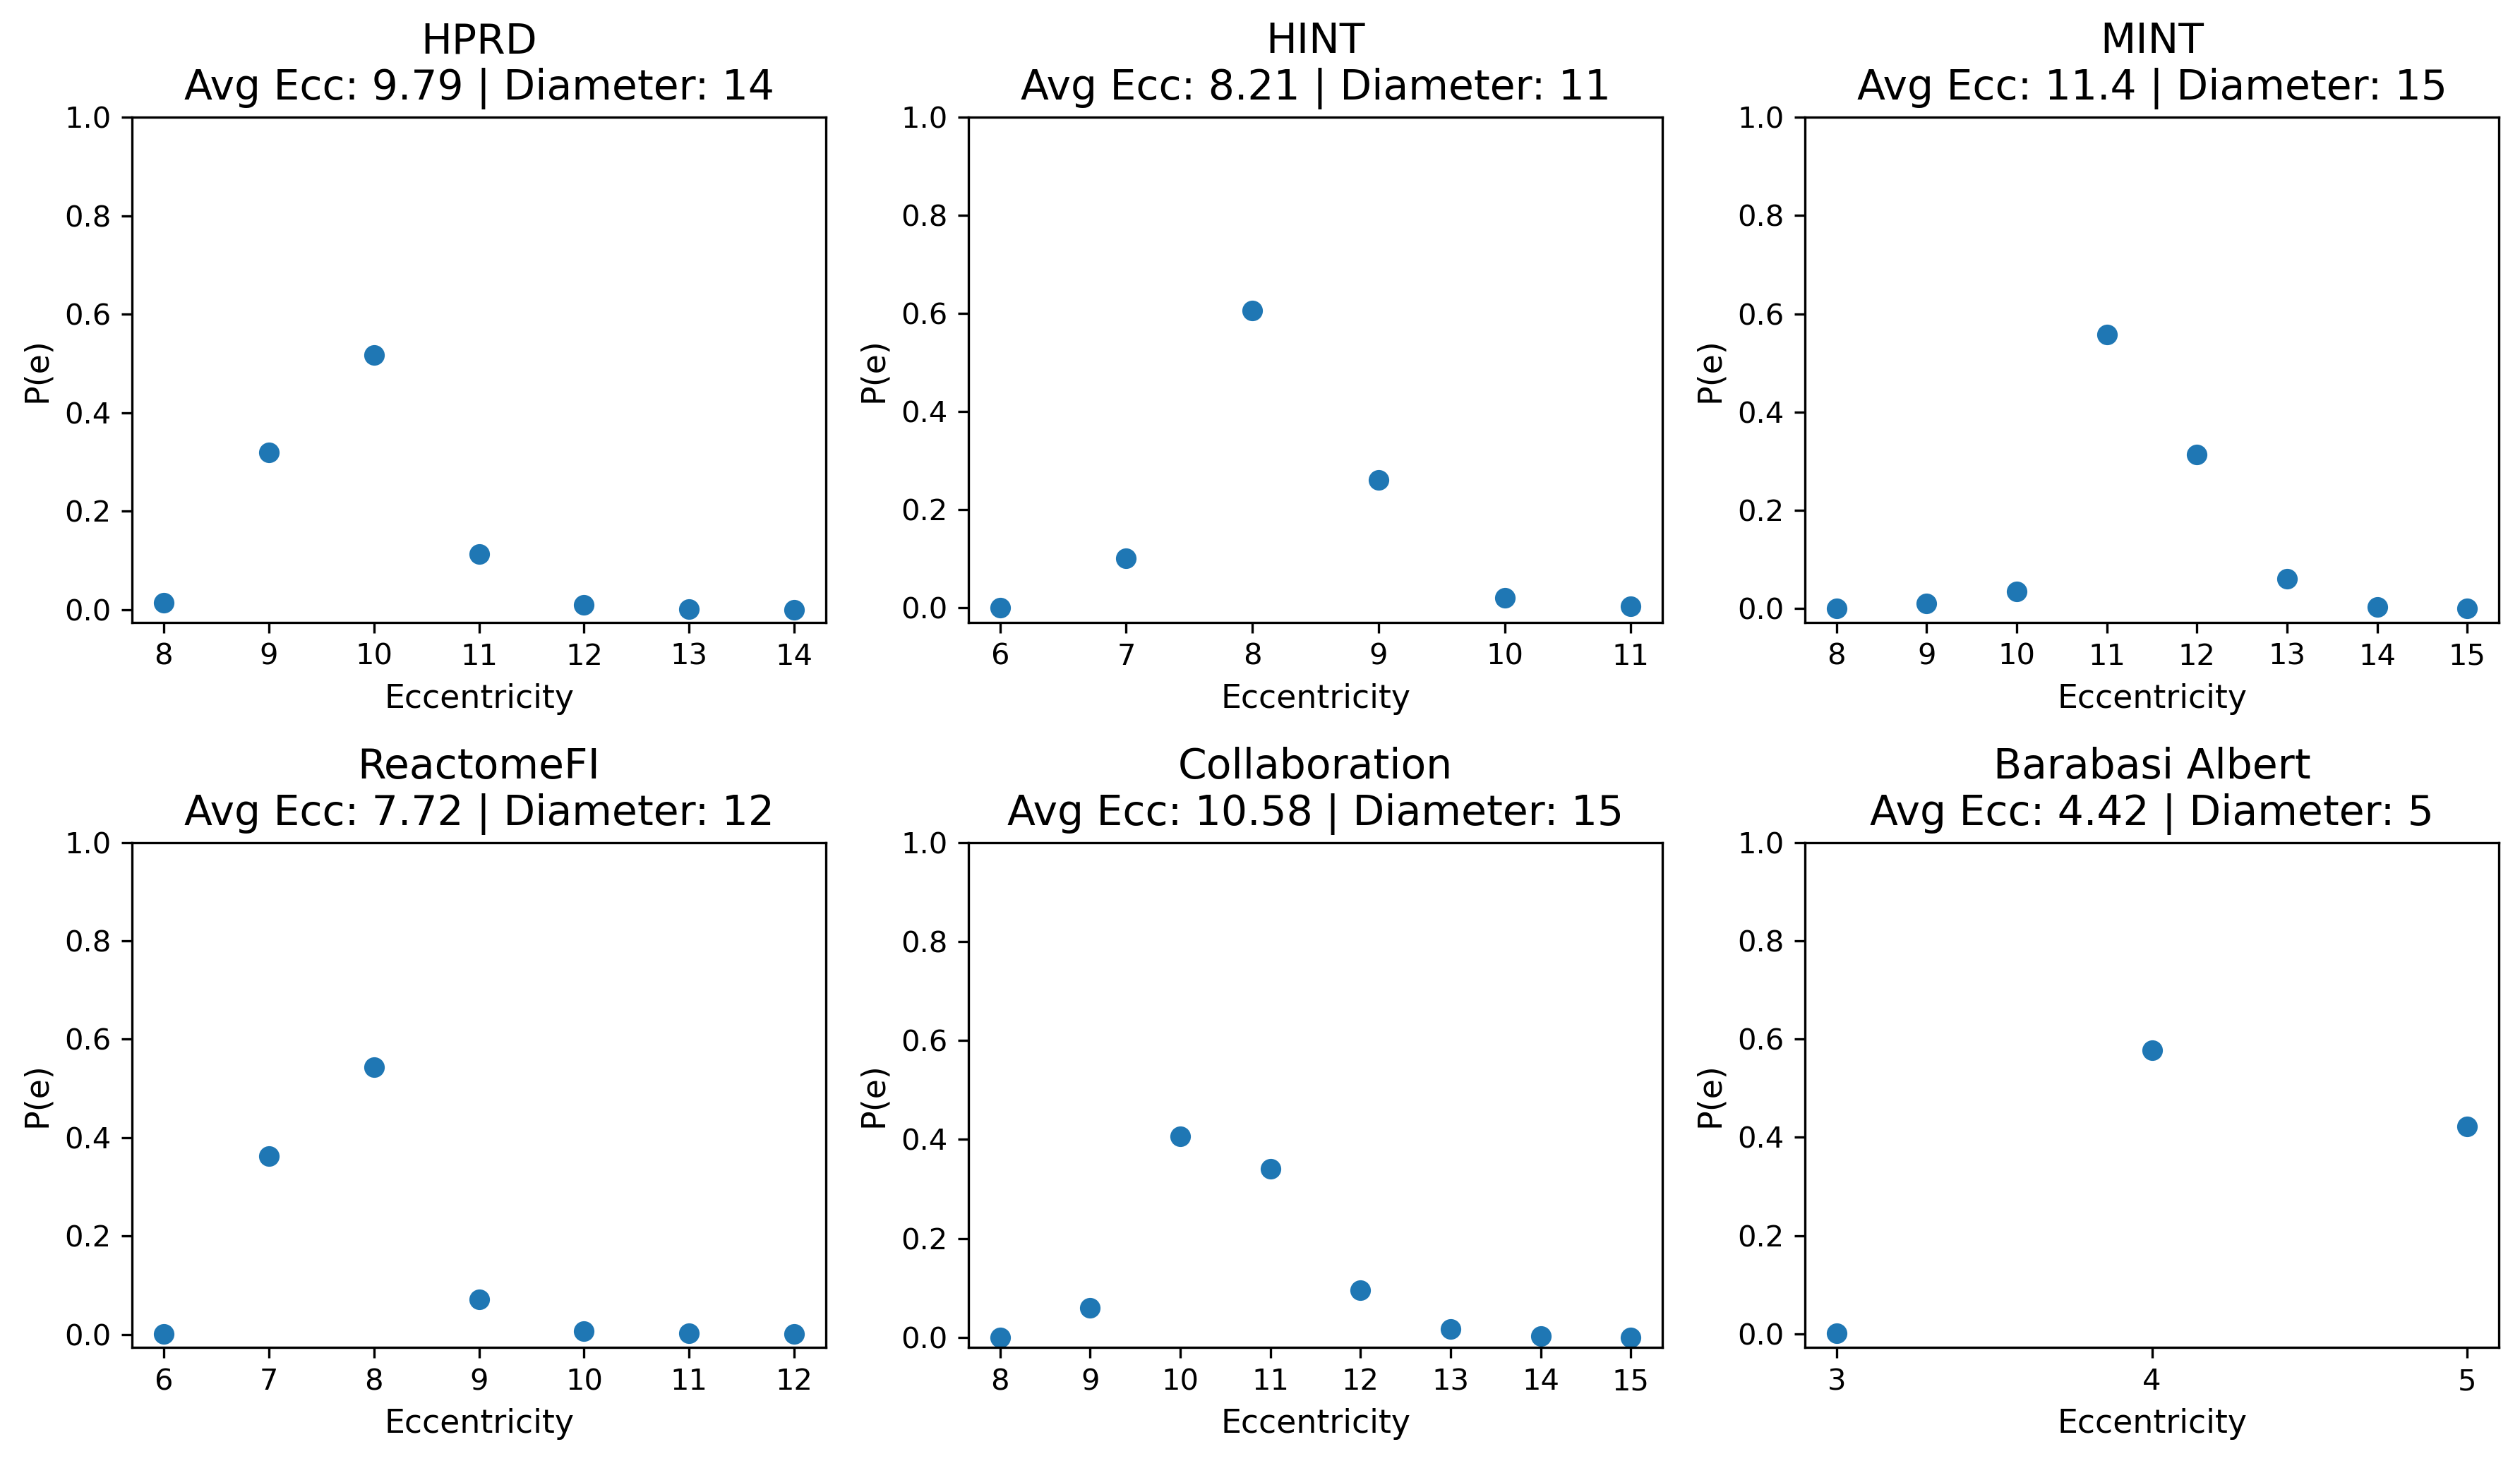

In [7]:
plt.figure(figsize=(12,7),dpi=300)  
for i,name in enumerate(networks):
    plt.subplot(2,3,i+1)
    
    avgSP = round(np.mean(measuresDataFrames[name]['Eccentricity']),2)
    diameter=round(max(measuresDataFrames[name]['Eccentricity']))

    eccentricityProb={}
    total = len(measuresDataFrames[name]['Eccentricity'])
    for c in measuresDataFrames[name]['Eccentricity']:
        if c in eccentricityProb:
            eccentricityProb[c]+=1
        else:
            eccentricityProb[c]=1

    for c in eccentricityProb:
        eccentricityProb[c]=eccentricityProb[c]/total

    eccentricityProb = dict(sorted(eccentricityProb.items(), key=lambda x:x[0]))

    plt.plot(list(eccentricityProb.keys()),list(eccentricityProb.values()),'o')
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xticks(sorted(set(measuresDataFrames[name]['Eccentricity'].dropna())))
    plt.xlabel("Eccentricity",fontsize=11)
    plt.ylabel("P(e)",fontsize=11)
    plt.title(name+'\nAvg Ecc: '+str(avgSP)+' | Diameter: '+str(diameter),fontsize=14)
    plt.tight_layout()

plt.savefig("ouput/3.2 Eccentricity.png", format='png', dpi=550)
plt.savefig("ouput/3.2 Eccentricity.pdf", format='pdf')
plt.show()

# Communities - execution time

In [22]:
G = nx.barbell_graph(5,2)

In [23]:
%%time
naiveGreedy= list(nx.community.naive_greedy_modularity_communities(G))

Wall time: 49.1 ms


In [24]:
%%time
greedy= list(nx.community.greedy_modularity_communities(G))

Wall time: 1.12 ms


In [25]:
sizes = [len(c) for c in naiveGreedy]
print('Naive Greedy - Modules: '+str(len(sizes))+' | '+'AvgLength: '+str(int(np.mean(sizes))))

Naive Greedy - Modules: 3 | AvgLength: 4


In [26]:
sizes = [len(c) for c in greedy]
print('Greedy - Modules: '+str(len(sizes))+' | '+'AvgLength: '+str(int(np.mean(sizes))))

Greedy - Modules: 3 | AvgLength: 4
